In [1]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import time
import signal

In [2]:
from skvideo.io import FFmpegWriter
from IPython.display import HTML
import base64
import io

In [3]:
from compute import *

%load_ext autoreload
%autoreload 2

In [4]:
ctx = cl.create_some_context()

In [5]:
class Scene:
    def __init__(self, ctx, size, scale=2):
        self.context = ctx
        self.size = size
        self.shape = (size[1], size[0])
        
        self.scale = scale
        self.upsize = [s*self.scale for s in size]
        self.upshape = (self.upsize[1], self.upsize[0])
        
        self.queue = cl.CommandQueue(ctx)
        with open("compute.cl", "r") as f:
            self.program = cl.Program(self.context, f.read()).build()
        
        self.depth_img = Image2D(
            self.context,
            np.zeros(self.upshape, dtype=np.float32),
            fmt=cl.ImageFormat(cl.channel_order.R, cl.channel_type.FLOAT)
        )
        
        self.color_img = Image2D(
            self.context,
            np.zeros((*self.shape, 4), dtype=np.float32), 
            rw=cl.mem_flags.WRITE_ONLY, 
            fmt=cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.FLOAT),
        )
        
    def load_depth(self):
        self.depth_img.load(self.queue)
        return self.depth_img.host
    
    def load_color(self):
        self.color_img.load(self.queue)
        return self.color_img.host
        
    def compute(self, pos, zoom, max_depth=0x100, julia=None):
        jpos = (0,0) if julia is None else julia
        self.program.compute(
            self.queue,
            self.upsize,
            None,
            self.depth_img.buf,
            np.array(pos, dtype=np.float32),
            np.array(zoom, dtype=np.float32),
            np.array([max_depth], dtype=np.int32),
            np.array([julia is not None], dtype=np.int32),
            np.array(jpos, dtype=np.float32),
        )
        return self.load_depth()
    
    def colorize(self, colors, period=1.0):
        color_map = Image1D(
            self.context,
            np.array(colors, dtype=np.float32),
            fmt=cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.FLOAT)
        )
        self.program.colorize(
            self.queue,
            self.size,
            None,
            self.depth_img.buf,
            self.color_img.buf,
            np.array([self.scale], dtype=np.int32),
            color_map.buf,
            np.array([period], dtype=np.float32)
        )
        return self.load_color()


In [6]:
def display_depth(depth_buffer, max_depth):
    display(Image.fromarray((255*np.log(np.maximum(depth_buffer, 0) + 1)/np.log(max_depth + 1)).astype(np.uint8)))

def display_color(color_buffer):
    display(Image.fromarray((255*color_buffer).astype(np.uint8)))

In [72]:
def cmul(a, b):
    return np.stack((a[0]*b[0] - a[1]*b[1], a[0]*b[1] + a[1]*b[0]))

def zmap(p, size, pos, zoom):
    ss = [2] + [-1]*(len(p.shape) - 1)
    sp = (p - 0.5*np.array(size).reshape(*ss))/min(*size)
    return np.array(pos).reshape(*ss) + cmul(np.array(zoom), sp)

def itop(indices, shape):
    return np.stack((indices % shape[1], indices // shape[1]))

In [73]:
def exp_sample(depth_buffer, num, temp):
    prob_map = depth_buffer.reshape(-1)
    prob_map[np.greater(0, prob_map)] = float("-inf");
    prob_map -= np.max(prob_map)
    prob_map = np.exp(temp[0]*prob_map)
    prob_map /= sum(prob_map)
    return np.random.choice(len(prob_map), num, p=prob_map, replace=True)

def median_sample(depth_buffer, num, temp):
    prob_map = depth_buffer.reshape(-1)
    low = np.percentile(prob_map, 100*(1.0 - temp[0]))
    high = np.percentile(prob_map, 100*(1.0 - temp[1]))
    mask = np.greater(prob_map, low)*np.less(prob_map, high)
    indices = np.where(mask)[0]
    return np.random.choice(indices, num, replace=True)

In [74]:
def search(
    scene, 
    pos=(-0.8, 0), 
    zoom=(2.4, 0), 
    max_depth=256, 
    temp=(0.1, 0.01), 
    n=1,
    pix=False,
):
    depth_buffer = scene.compute(pos, zoom, max_depth=max_depth).copy()
    idxs = median_sample(depth_buffer, n, temp)
    pps = itop(idxs, depth_buffer.shape)
    if (pix):
        return pps.transpose()
    return zmap(pps, depth_buffer.shape[::-1], pos, zoom).transpose()

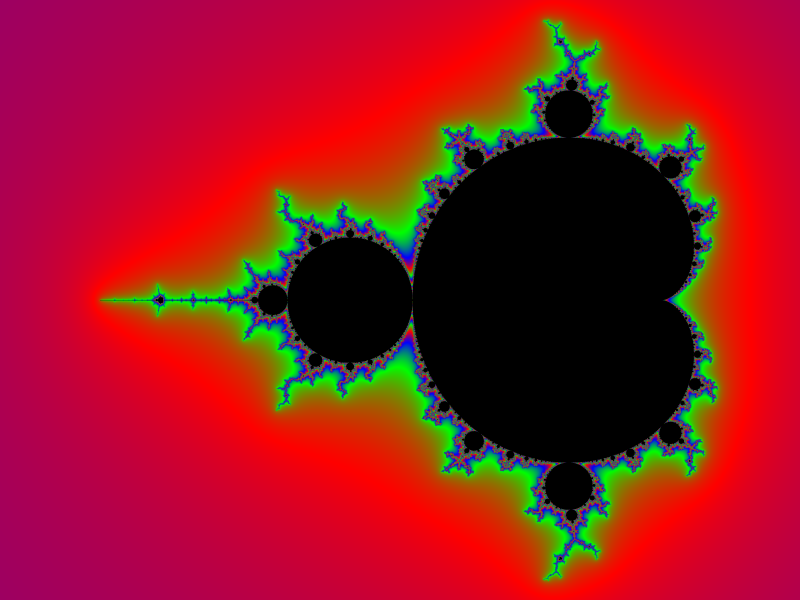

In [75]:
scene = Scene(ctx, (800, 600), scale=4)
scene.compute((-0.8, 0), (2.4, 0), max_depth=1024)
display_color(scene.colorize([[1,0,0,1], [0,1,0,1], [0,0,1,1]], period=20))

In [76]:
tiny_scene = Scene(ctx, (480, 420), scale=1)

In [77]:
search(tiny_scene, n=3, max_depth=256)

array([[ 0.29142857, -0.00571429],
       [ 0.09142857, -0.69142857],
       [-1.38857143,  0.02857143]])

In [88]:
temp = (0.2, 0.1)

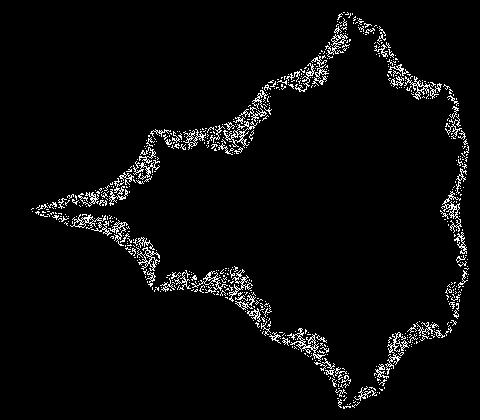

In [90]:
field = np.zeros(tiny_scene.shape, dtype=np.uint8).reshape(-1)
points = search(tiny_scene, n=10000, temp=temp, pix=True)
points = points[:,0] + points[:,1]*tiny_scene.shape[1]
field[points] = 255
display(Image.fromarray(field.reshape(*tiny_scene.shape)))

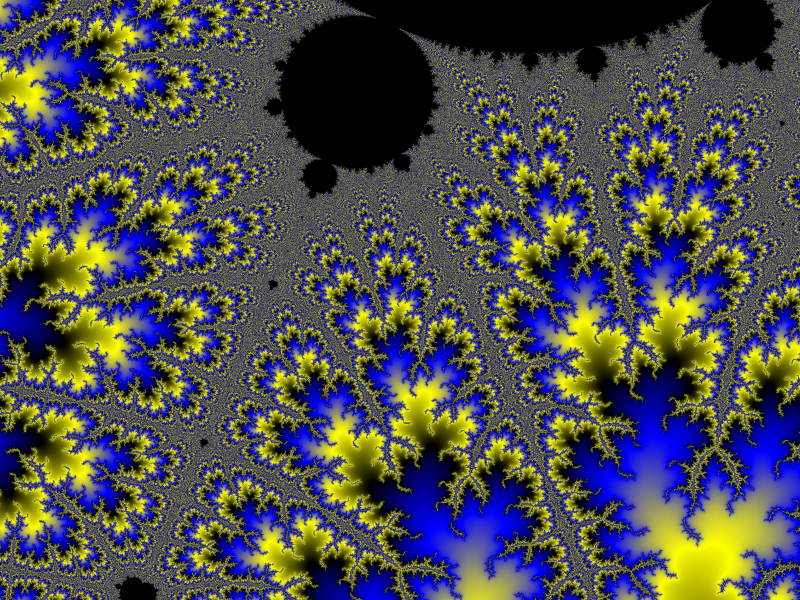

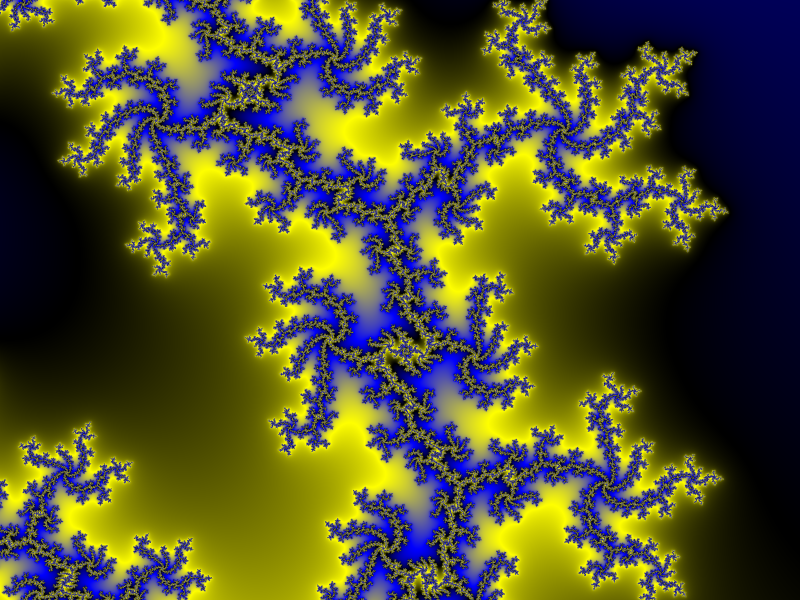

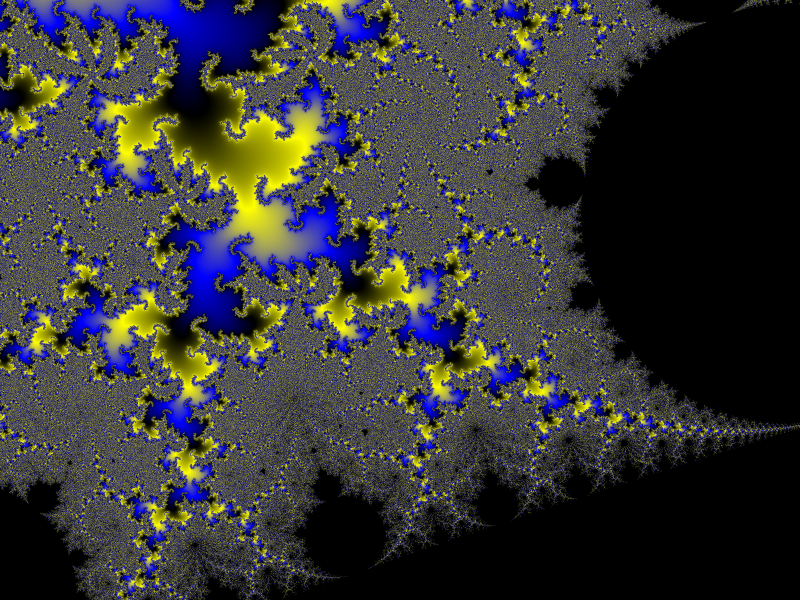

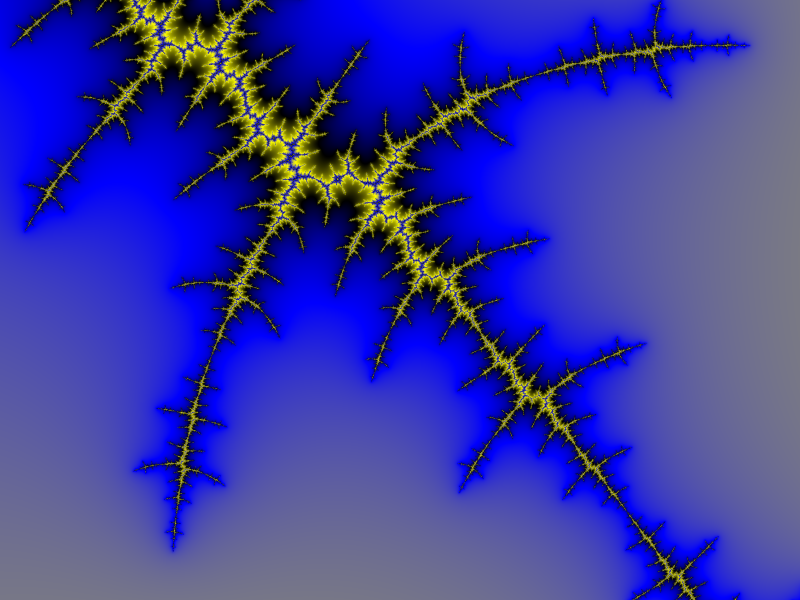

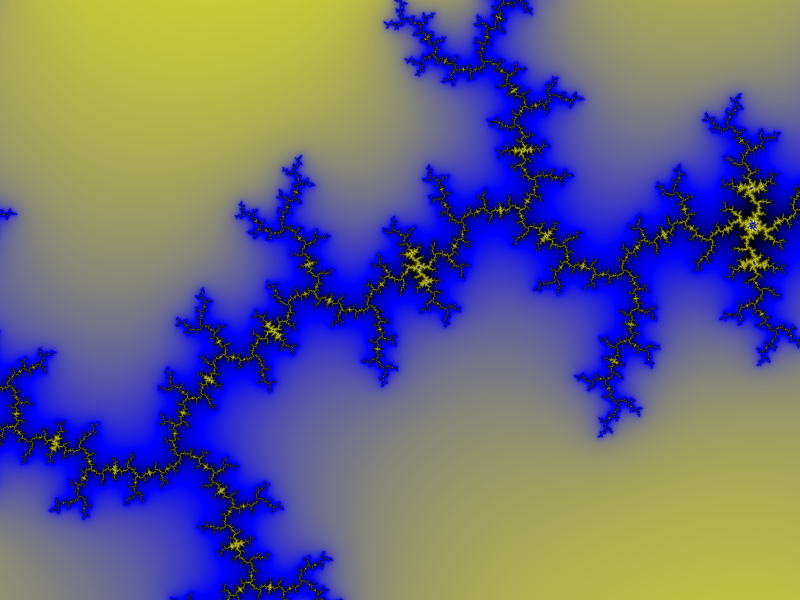

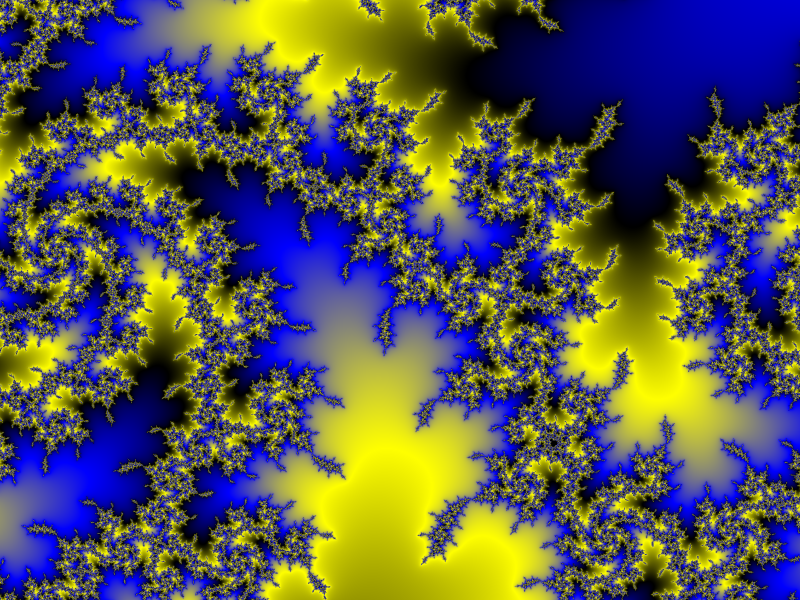

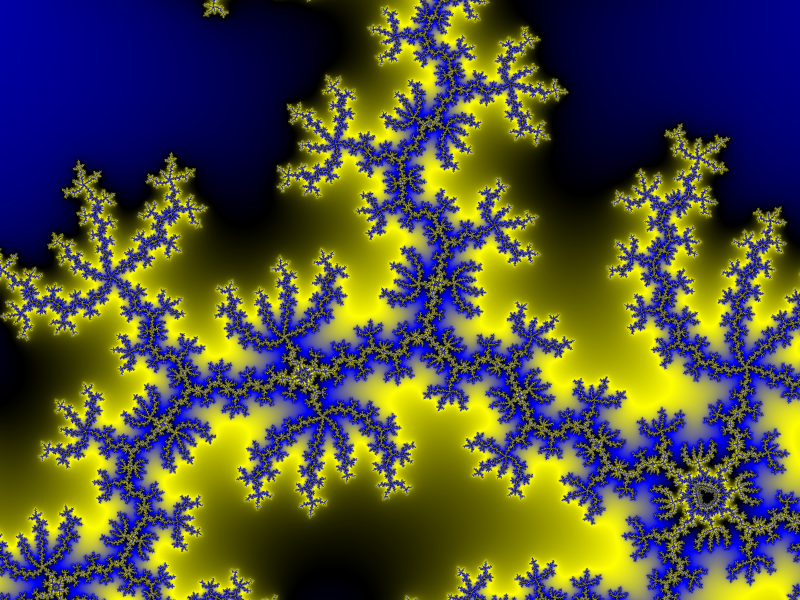

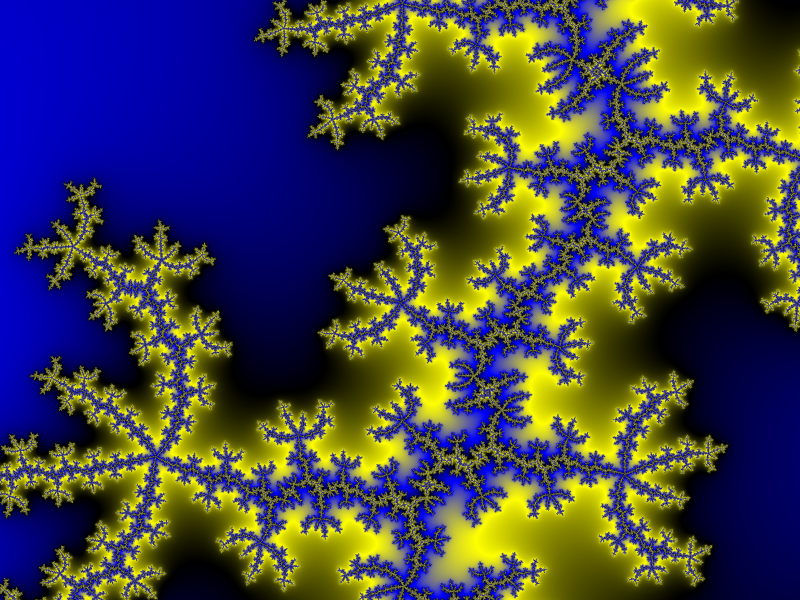

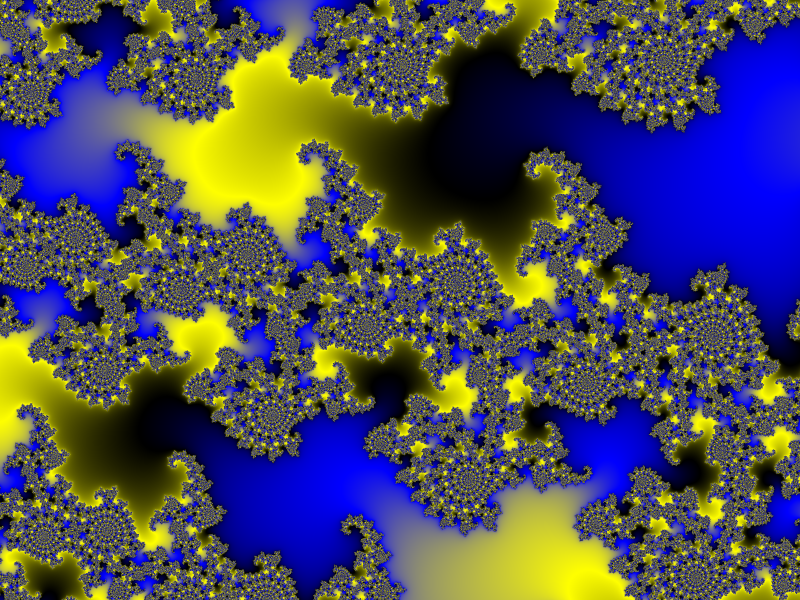

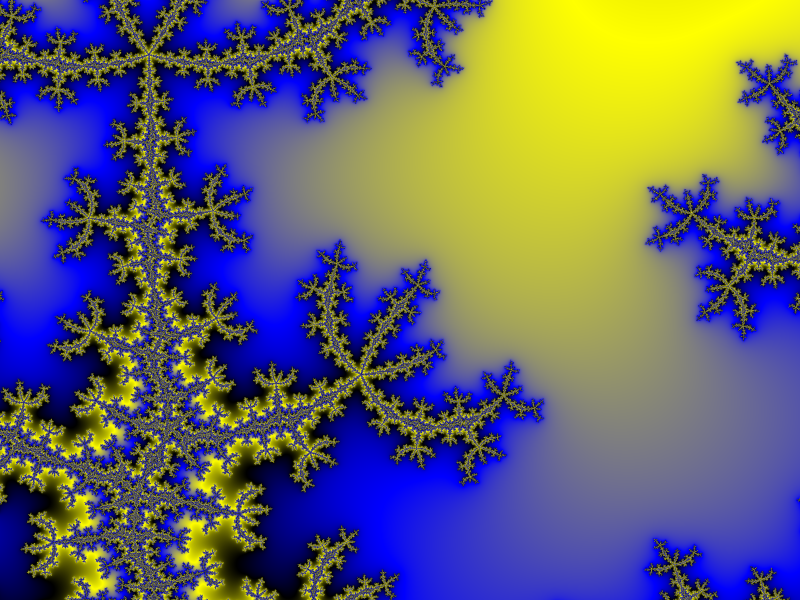

In [93]:
def draw(scene, color_map):
    display_color(scene.colorize(color_map, period=50))

color_map = [[0,0,0,1], [1,1,0,1], [0,0,1,1]]
md = 1024

for k in range(10):
    pos = search(tiny_scene, max_depth=md, temp=t)[0]
    #draw(tiny_scene, color_map)
    zoom = 2.0
    for i in range(6):
        zoom /= 4
        pos = search(tiny_scene, pos=pos, zoom=(zoom,0), max_depth=md, temp=t)[0]
        #draw(tiny_scene, color_map)

    scene.compute(pos, (zoom,0), max_depth=4096)
    draw(scene, color_map)